### Table of Contents
- Intro
- Nowcast
- Using Nowcast to improve Forecast



## Introduction


Forecasting in the presence of reporting delay: simulation study. Given some delayed data, can we use the method described in Gibson, Reich, Ray to improve forecasts based on predicted values of nowcasting. 

Strategy


- Generate data for t=0..100
- Delay data from t=90..100 according to fixed delay proportions
- Fit delay model to data
- Generate nowcasts 
- Retrain process model on nowcasts (t=90..100)
- Forecast t=100-110 using updated process model and original process model 
- Compare MSE


**Updated process model should perform better on 1-10 k step ahead t0=100 predictions**

## Simulation Study, fixing delay proportions and improving nowcast

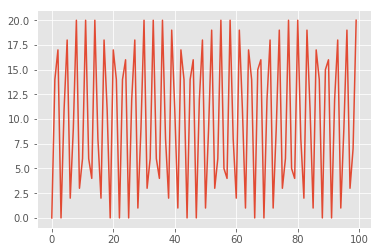

In [66]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
ts = 20*np.sin(np.arange(0,100))**2 #+  .01*np.random.standard_normal(size=100)
ts = np.round(ts)
plt.plot(ts)
plt.show()

Suppose we have time-varying delay at time 80-100

In [67]:
p_vec = np.random.dirichlet(np.ones(10),size=1)[0]
print (p_vec)

[0.06199618 0.03909984 0.24755186 0.0529726  0.1347601  0.02040851
 0.19881526 0.06800914 0.05532866 0.12105787]


If the true delay distribution is given by 
$$p_1,...,p_{10} \sim Dirichlet(\alpha_1,...,\alpha_{10})$$

In [68]:
# we choose 10 data points to apply the partially observed mask to

data_to_be_delayed = ts[90:]
print (data_to_be_delayed)

[16.  0. 12. 18.  1.  9. 19.  3.  7. 20.]


In [69]:
tmp = []
count = 10
for y_t in data_to_be_delayed:
    tmp.append(y_t*sum(p_vec[:count]))
    count -=1
data_to_be_delayed = np.round(tmp)   
print (data_to_be_delayed)

# data to be delayed now contains the dirichlet proportions

[16.  0. 10. 14.  1.  5.  8.  1.  1.  1.]


In [70]:
delayed_data = np.append(ts[:90],data_to_be_delayed)

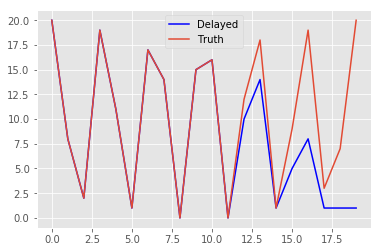

In [71]:
plt.plot(delayed_data[80:],color='b')
plt.plot(ts[80:])
plt.legend(("Delayed","Truth"))
plt.show()

In [72]:
print (ts)
print (delayed_data)

[ 0. 14. 17.  0. 11. 18.  2.  9. 20.  3.  6. 20.  6.  4. 20.  8.  2. 18.
 11.  0. 17. 14.  0. 14. 16.  0. 12. 18.  1.  9. 20.  3.  6. 20.  6.  4.
 20.  8.  2. 19. 11.  1. 17. 14.  0. 14. 16.  0. 12. 18.  1.  9. 19.  3.
  6. 20.  5.  4. 20.  8.  2. 19. 11.  1. 17. 14.  0. 15. 16.  0. 12. 18.
  1.  9. 19.  3.  6. 20.  5.  4. 20.  8.  2. 19. 11.  1. 17. 14.  0. 15.
 16.  0. 12. 18.  1.  9. 19.  3.  7. 20.]
[ 0. 14. 17.  0. 11. 18.  2.  9. 20.  3.  6. 20.  6.  4. 20.  8.  2. 18.
 11.  0. 17. 14.  0. 14. 16.  0. 12. 18.  1.  9. 20.  3.  6. 20.  6.  4.
 20.  8.  2. 19. 11.  1. 17. 14.  0. 14. 16.  0. 12. 18.  1.  9. 19.  3.
  6. 20.  5.  4. 20.  8.  2. 19. 11.  1. 17. 14.  0. 15. 16.  0. 12. 18.
  1.  9. 19.  3.  6. 20.  5.  4. 20.  8.  2. 19. 11.  1. 17. 14.  0. 15.
 16.  0. 10. 14.  1.  5.  8.  1.  1.  1.]


First suppose we have the true delay proportions. 
$$N_{t,\infty} | N_{t,d} \propto N_{t,d} | N_{t,\infty} \cdot N_{t,\infty}$$

In [73]:
n_t_d = data_to_be_delayed



Lets fit an $AR$-state space model of the form 
$$Y_t \sim N(X_t,\sigma_y^2)$$
$$X_t \sim N(\phi_1X_{t-1},\sigma_x^2)$$

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


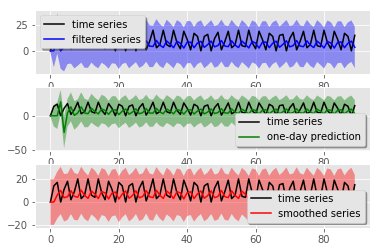

In [74]:
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
myDLM = dlm(ts[:90])

myDLM = myDLM + autoReg(degree=2, data=ts[:90], name='ar2', w=1.0)
myDLM.fit()
br =  myDLM.getMean(filterType='forwardFilter')
(predictMean, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)
myDLM.plot()

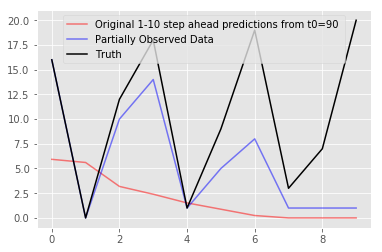

In [75]:
n_t_inf_hat = predictMean
plt.plot(n_t_inf_hat,color='r',alpha=.5)
plt.plot(data_to_be_delayed,color='b',alpha=.5)
plt.plot(ts[90:],color='black')
plt.legend(("Original 1-10 step ahead predictions from t0=90 ","Partially Observed Data","Truth"))
plt.show()

Finally we perform the re-weighting.

In [76]:
num_mc_samples = 1000
reweighted_trajectory = []
from  scipy.stats import binom
count = 10
for t in range(len(n_t_inf_hat)):
    likelihood_previous = -100000
    likelihood_current = -1000000
    tmp = 0
    for s in range(num_mc_samples):
        fcast = np.random.normal(n_t_inf_hat[t],np.sqrt(predictVar[t]))
        likelihood_current = binom.logpmf(data_to_be_delayed[t],fcast,sum(p_vec[:count])-.000000000001)
        #print (data_to_be_delayed[t],fcast,sum(p_vec[:count]),likelihood_current)
        if likelihood_current > likelihood_previous:           
            likelihood_previous = likelihood_current
            tmp = fcast
    #print (len(tmp))
    reweighted_trajectory.append(tmp)
    
    count -=1 

In [77]:
reweighted_trajectory

[16.01841630585421,
 0.033713629756703334,
 11.600827286685405,
 18.011063617640907,
 1.2466311559210004,
 8.814800488796823,
 19.38165274138362,
 2.321264747412357,
 9.383714262392568,
 15.56841335767331]

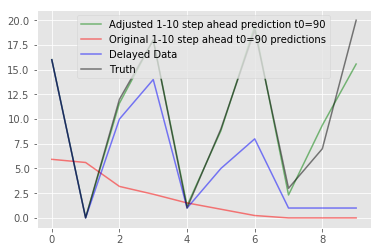

[]

In [78]:
plt.plot(reweighted_trajectory,color='g',alpha=.5)
plt.plot(n_t_inf_hat,color='r',alpha=.5)
plt.plot(data_to_be_delayed,color='b',alpha=.5)
plt.plot(ts[90:],color='black',alpha=.5)
plt.legend(('Adjusted 1-10 step ahead prediction t0=90','Original 1-10 step ahead t0=90 predictions','Delayed Data','Truth'))
plt.show()
plt.plot()

## Using nowcast to improve forecast




In [79]:

## get predictions for 90-100 from nowcast
new_training_data = np.nan_to_num(np.append(ts[:90],reweighted_trajectory))
myDLM = dlm(new_training_data)

myDLM = myDLM + autoReg(degree=2, data=new_training_data, name='ar2', w=1.0)
myDLM.fit()
br =  myDLM.getMean(filterType='forwardFilter')
(predictMeanRetrain, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)



Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


In [80]:
ts

array([ 0., 14., 17.,  0., 11., 18.,  2.,  9., 20.,  3.,  6., 20.,  6.,
        4., 20.,  8.,  2., 18., 11.,  0., 17., 14.,  0., 14., 16.,  0.,
       12., 18.,  1.,  9., 20.,  3.,  6., 20.,  6.,  4., 20.,  8.,  2.,
       19., 11.,  1., 17., 14.,  0., 14., 16.,  0., 12., 18.,  1.,  9.,
       19.,  3.,  6., 20.,  5.,  4., 20.,  8.,  2., 19., 11.,  1., 17.,
       14.,  0., 15., 16.,  0., 12., 18.,  1.,  9., 19.,  3.,  6., 20.,
        5.,  4., 20.,  8.,  2., 19., 11.,  1., 17., 14.,  0., 15., 16.,
        0., 12., 18.,  1.,  9., 19.,  3.,  7., 20.])

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[]


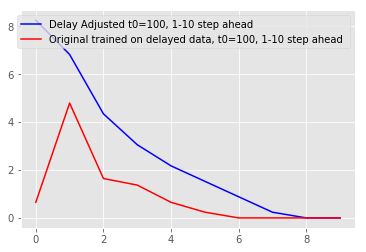

RETRAINED
114.49916747123598
ORIGINAL
132.41284498076243


In [83]:
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
myDLM = dlm(ts)

myDLM = myDLM + autoReg(degree=2, data=delayed_data, name='ar2', w=1.0)
myDLM.fit()
br =  myDLM.getMean(filterType='forwardFilter')
(predictMean, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)
print (predictMean[10:])
from sklearn.metrics import mean_squared_error
plt.plot(predictMeanRetrain,color='b')
plt.plot(predictMean,color='r')
plt.legend(("Delay Adjusted t0=100, 1-10 step ahead ","Original trained on delayed data, t0=100, 1-10 step ahead "))
plt.show()

truth =  20*np.sin(np.arange(100,110))**2
print ("RETRAINED")
print (mean_squared_error(predictMeanRetrain,truth))
print ("ORIGINAL")
print (mean_squared_error(predictMean,truth))